In [65]:
import numpy as np
import pandas as pd
import networkx as nx
import gradco as gradco
from scipy import sparse
from scipy.spatial.distance import pdist,squareform
from utils import map_entrez_to_symbol, compute_GDV_similarity_matrix
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from plots import spring_embedding, plot_embedding, plot_case_and_background_GDVs, plot_two_distributions

# Tutorial: topology aware network embeddings for cancer gene predictions 

Topological methods, i.e., methods that discribe the local structure of a network, are widely used to predict disease genes.
State-of-the-art approaches to summarise the topology of a node in a network are based on graphlets: small, non-isomorphic induced sub-graphs. To improve the performance of downstream tasks, rather than mining the network directly, current approaches first learn latent representations of the network, so that nodes that are similar in terms of topology have similar representations. These representations are also known as node embeddings, as the nodes are interpreted as to be projected (i.e., embedded) in an space so that they have similar coordinates in that space if they have similar topology.   

In this tutorial, we guide you, the user, to compute graphlet-based node embeddings and to use them to predict cancer related genes. As known cancer drivers we consider all the known drivers in the IntOGen cancer driver database (regardless of the type of cancer). As a network, we consider the human Protein-Protein Interaction network by default, collected from the BioGRID.

This tutorial consists of the following steps:

1. Reading the input data and reading/computing graphlet-based features.
2. Validating that known cancer drivers have a topological signature using Graphlet Degree Vectors (GDV).
3. Validating that GDV similarity, which measures the topological similarity between two nodes based on their GDV, can distinguish known cancer drivers from non-cancer drivers.
4. Using the pairwise GDV similarity between al the genes and the LINE embedding algorithm to learn an embedding space that captures node topological similarity.
5. Using clustering and enrichment to predict new cancer-related genes.
6. We provide extenions in the form of alternative graphlet-based measurs and embedding algorithms that can be used to compute various variations of topological node embeddings. 

The user is guided to implement various algorithms from scratch using libraries commonly used in the field: [networkx](https://networkx.org/documentation/stable/reference/index.html), [numpy](https://numpy.org/doc/stable/user/index.html#user), [scipy](https://docs.scipy.org/doc/scipy/reference/index.html#scipy-api). 


# 1. Reading the input data and reading/computing graphlet based features

## 1.1. Reading the input network and cancer driver labels

Here we: 
1. Read the network (human PPI by default). The network is provided as an edgelist. We read the edgelist to create a networkx Graph object called 'G'.
2. Read the cancer driver labels. The labels are formated as an n-dimensional binary vector called 'driver_status'. This vector is aligned with G.nodes(), so that the $i$th entry in driver_status is 1 if the $i$th node in G.nodes() a known cancer driver and 0 otherwise. 

You are asked to complete the function "read_edgelist" below, which reads an edgelist from a file and returns a networkx Graph object ([networkx docs](https://networkx.org/documentation/stable/reference/index.html)).  


In [5]:
def read_edgelist(filename):
    """ Read a graph from a file and return a networkx graph object.

    Parameters:
    -----------
    filename: str
    
    Returns:
    --------
    G: networkx.Graph
    """    
    
    # TODO:
    # replace the line below and read the edgelist stored under <filename>. 
    # To avoid issues with entrez ids, ake sure the nodes labels are read as strings (i.e., set 'nodetype' to str)
    G = nx.Graph()
    G = nx.read_edgelist(filename, nodetype=str)

    # assert more than 0 nodes
    assert G.number_of_nodes() > 0, "Graph has no nodes"
    
    # assert more than 0 edges
    assert G.number_of_edges() > 0, "Graph has no edges"

    # assert node type is str
    assert isinstance(list(G.nodes())[0], str), "Nodes are not integers"

    # assert G is a Graph
    assert isinstance(G, nx.Graph), "G is not a Graph"

    return G


In [6]:
net_name = "PPI_human" 

# DON'T CHANGE ANYTHING HERE
G = read_edgelist(f'data/networks/{net_name}.edgelist') 
# An binary array that has been aligned with G.nodes() (i.e., the nodes/genes in the network )
driver_status = np.loadtxt(f'data/cancer/intogen_{net_name}.txt')


In [ ]:
spring_embedding(G)

## 1.2. Computing/reading GDV vectors

Here we use our Graphlet-orbit ADjacency Counter ([GRADCO](https://pypi.org/project/gradco/)) to compute graphlet degree vectors. 
As GRADCO is quite memory intensive and can take some time to compute (~5 minutes for the human PPI network, 16 GB of ram), we provide the option below to: (1) run GRADCO or (2) to read precomputed GDV vectors (under '/features/GDVs/')

### Option 1: running GRADCO to compute GDVs

In [7]:
# A = nx.to_scipy_sparse_array(G)  # converts the network to a sparse scipy matrix 
# counter = gradco.Counter(A)  # initalises GRADCO counting object
# counter.count()  # perform the counting
# GDVs = counter.get_GDVs()

### Option 2: reading precomputed GDVs graphlet adjacencies and orbit adjacencies

In [8]:
GDVs = np.loadtxt(f'features/GDVs/GDVs_{net_name}.txt')
assert len(GDVs) == G.number_of_nodes(), 'The network and GDV file should match'

# 2. Validating that cancer drivers have a topological signature 

Here, we first illustrate that cancer drivers have a different topological signature than non-drivers (i.e., all genes not listed as a driver in IntOGen). Above, we computed the GDV vectors for all nodes in the network, to describe the topology of the nodes in our network in terms of the number of times it occurs on each of the different graphlet orbits. Here, to show that cancer drivers have a different topology than non-drivers, we compare the average GDV vector of known drivers to genes that of the remaining genes in the network. You are asked to complete the function 'split_GDV_into_drivers_and_non_drivers', to split the array of GDVs for all nodes in the network into an array of GDVs for drivers and one for non-drivers.

In [9]:
def split_GDV_into_drivers_and_non_drivers(driver_status, GDVs):
    """ Use the driver status to split the GDVs into driver and non-driver GDVs. 

    parameters:
    -----------

    driver_status: np.ndarray (n,)
        Array of driver status for n nodes. 1 if node is a driver, 0 otherwise.
    GDVs: np.ndarray (n x 15)
        Array of graphlet degree vectors (GDVs) for n nodes and 15 orbits.

    returns
    -------

    driver_GDVs: np.ndarray (m x 15)
    background_GDVs: np.ndarray (k x 15)

    """

    # TODO: split the GDVs into driver and background GDVs.
    driver_GDVs = []
    background_GDVs = []
    driver_GDVs = GDVs[driver_status == 1]
    background_GDVs = GDVs[driver_status == 0]

    assert len(background_GDVs) + len(driver_GDVs) == len(GDVs)

    return driver_GDVs, background_GDVs

Below we plot the GDV vectors of drivers and non-driver genes. We make two observations:
1. Driver genes indeed have different signature than non-driver genes
2. The orbit counts for different orbits are different in scale. For instance, in general nodes occur much more on orbits 4 and 5 than on orbits 2 and 14. This is because networks tend to be sparsely connected, hence sparse graphlets occur more often.

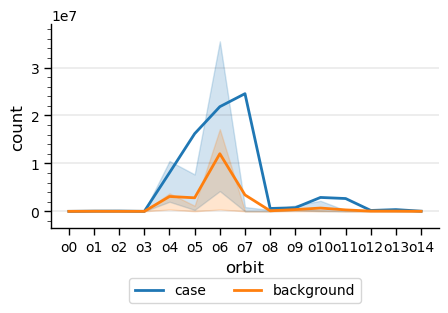

In [10]:
#. DON'T CHANGE ANYTHING HERE
driver_GDVs, background_GDVs = split_GDV_into_drivers_and_non_drivers(driver_status, GDVs)
ax = plot_case_and_background_GDVs(driver_GDVs, background_GDVs)

To use GDV signatures as a way to predict new cancer drivers, we need a way to measure the similarity between two GDVs. For that we have the GDV similarity.

# 3. Validating that GDV similarity can distinguish cancer drivers and non-cancer drivers

In this section, we want to evaluate if the GDV similarity, which measures the topological similarity between two nodes based on their gDV vectors, can distinguish between driver and non-driver genes. We compare the distribution of GDV similaritys between (1) drivers and drivers (2) drivers and non-drivers. You are asked to correctly implement the GDV distance, defined next.


## GDV distace and GDV similarity 


The GDV distance measures the topological difference between two nodes based on their GDV vectors.
Let $h$ and $c$ be the GDV vectors of two nodes. Then their distance, $D_i$, for each orbit defined as: 


$$D_i\left( {{h},{c}} \right) = w_i \times \frac{{\left| {{\mathrm{log}}\left( {h_i + 1} \right) - {\mathrm{log}}\left( {{c}_i + 1} \right)} \right|}}{{{\mathrm{log}}\left( {{\mathrm{max}}\left\{ {{h}_i,{c}_i} \right\} + 2} \right)}},$$



where:
- $i$ represents 11 non-redundant orbits: $i \in \{1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12\}$
- $o_i$ are the orbit importances for the 11 non-reduntant orbits:  $[1,2,2,3,4,3,3,4,3,4,4]$
- $w_i$ scales the contribution of each orbit to the overal GDV similarity by the importance of orbit $i$, $o+i$:

$$ w_i = 1- \frac{log(o_i)}{log(11)}$$


The GDV distance between $h$ and $c$ then is defined as:

$$D(h, c) = \frac{\sum_{i=1}^{11} D_i}{\sum_{i=1}^{11} w_i}$$

There are two key ideas behind this formula. 

Firstly, as stated, orbit counts for different orbits vary in scale. The log-transform brings the scales of the orbit counts closer together. We illustrate this by plotting the log-transformed GDVs of cancer and 

Secondly, there are correlations between the various orbit counts. To counter this, GDV similarity is computed over a subset of 11 non-redundant orbits and the importance of each orbit is weighted. 

Finally, GDV similarity, $S$, measures the topological similarity between two nodes:
$$S(h, c) = 1 - D(h, c)$$

Here, we ask you to implement of GDV_distance_function(gdv1, gdv1) below, so we can run our analysis. 

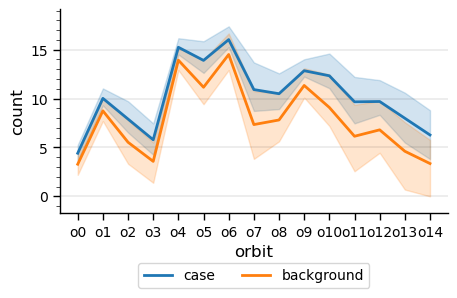

In [26]:
ax = plot_case_and_background_GDVs(np.log(driver_GDVs+1), np.log(background_GDVs+1))

In [19]:
def compute_GDV_distance(gdv1, gdv2):
    """ Compute the distance between two graphlet degree vectors (GDVs).

    parameters:
    -----------
    gdv1: np.ndarray (15,)
    gdv2: np.ndarray (15,)

    returns:
    --------
    distance: float
    
    """
    # 11 non redundant orbits
    non_redundant_orbits = np.array([1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12],
                                    dtype=int)

    weights = 1 - (np.log([1., 2., 2., 3., 4., 3., 3., 4., 3., 4., 4.]) / np.log(11.))

    # TODO 1 for each GDV vector, select the 11 non-redundant orbits
    gdv1 = gdv1[non_redundant_orbits]
    gdv2 = gdv2[non_redundant_orbits]

    assert len(gdv1) == 11, "GDV1 does not have 11 elements"
    assert len(gdv2) == 11, "GDV2 does not have 11 elements"

    # TODO 2 compute the gdv distance between the two GDVs 
    # TODO 2.1: logtransform the GDVs. add +1 to avoid log(0)
    log_gdv1 = np.log(gdv1 + 1)
    log_gdv2 = np.log(gdv2 + 1)

    assert (log_gdv1 < 0).sum() == 0, "Negative values in log_gdv1"
    assert (log_gdv2 < 0).sum() == 0, "Negative values in log_gdv2"
    assert np.isinf(log_gdv1).sum() == 0, "Inf values in log_gdv1"
    assert np.isinf(log_gdv2).sum() == 0, "Inf values in log_gdv2"

    # TODO 2.2: compute the difference between the two GDVs 
    diff = np.abs(log_gdv1 - log_gdv2)
    assert (diff < 0).sum() == 0, "Negative values in diff"

    # TODO 2.3: divide the difference by the log of the max of each entry in the GDVs +2
    diff = diff / np.log(np.maximum(gdv1, gdv2) + 2)
    assert (diff < 0).sum() == 0, "Negative values in diff"

    # TODO 2.4: multiply the difference by the weights
    diff = diff * weights

    # TODO 2.5: the distance compute the sum of the differences over the summed weights
    distance = np.sum(diff)/np.sum(weights)
    assert distance >= 0, "Distance is negative"

    return distance

# NOTHING TODO HERE
def compute_pairwise_GDV_distances(GDVs1 , GDVs2):
    """ Compute the pairwise distances between two sets of graphlet degree vectors (GDVs).

    parameters:
    -----------
    GDVs1: np.ndarray (n x 15)
        Array of graphlet degree vectors (GDVs) for n nodes and 15 orbits.
    GDVs2: np.ndarray (m x 15)
        Array of graphlet degree vectors (GDVs) for m nodes and 15 orbits.

    returns:
    --------
    distances: np.ndarray (n x m)
        Pairwise distances between the two sets of GDVs.
    """

    distances = []

    for i in range(GDVs1.shape[0]):
        for j in range(GDVs2.shape[0]):
            distances.append(compute_GDV_distance(GDVs1[i,:], GDVs2[j,:]))
    distances = np.array(distances)
    return distances

# NOTHING TODO HERE
def compute_GDV_similarity(gdv1, gdv2):
    """ Compute the similarity between two graphlet degree vectors (GDVs)."""
    return 1 - compute_GDV_distance(gdv1, gdv2)

# NOTHING TODO HERE
def sample_GDVs(GDVs, sample_size):
    """ Randomly sample a subset of GDVs. 

    parameters:
    -----------
    GDVs: np.ndarray (n x 15)
        Array of graphlet degree vectors (GDVs) for n nodes and 15 orbits.
    sample_size: int

    returns:
    --------

    sampled_GDVs: np.ndarray (sample_size x 15)
    """

    return GDVs[np.random.choice(GDVs.shape[0], sample_size, replace=False)]


Below we compare the distribution of GDV similaritys between (1) drivers and drivers (2) drivers and non-drivers.
To save on computational time, we only take a subset of the drivers and non-driver GDVs. We observe that the distances between drivers are lower than the distances between drivers background. This motivates us to use compute GDV similarity based node embeddings to enable the prediction of new cancer driver genes.



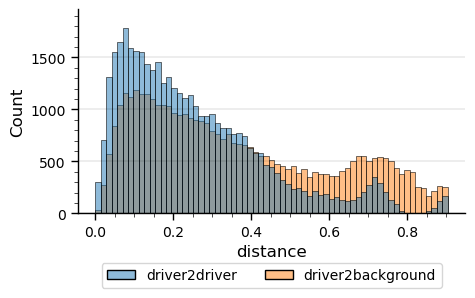

In [18]:
# DON'T CHANGE ANYTHING HERE
sample_size = 200
driver_GDVs_sample = sample_GDVs(driver_GDVs, sample_size)
background_GDVs_sample = sample_GDVs(background_GDVs, sample_size)

driver2driver = compute_pairwise_GDV_distances(driver_GDVs_sample, driver_GDVs_sample)
driver2background = compute_pairwise_GDV_distances(driver_GDVs_sample, background_GDVs_sample)
ax = plot_two_distributions(driver2driver, driver2background)

# 4. Topological node embeddings based on GDV simalarity and LINE

Having shown GDV similarity finds a measurable distance between drivers and non-drivers, we will use it to make new cancer driver gene predictions. To improve the performance of our predictions, rather than using the GDV similarity scores directly, we first learn an embedding space so that nodes with a similar GDV similarity are nearby in space. 


To learn an embedding space that captures the GDV similarity we apply LINE to the matrix of pairwise GDV similarities between all genes in the network. We label this matrix $A$. We can think of $A$ as the adjacency matrix of a weighted network in which the edges are the GDV similarity scores of our original network.

In a first step, LINE computes the pairwise mutual information between the GDV similarities of all nodes: $$PMI(i,j) = log \left(  \frac{ vol(A) \times A_{ij}}{d_i, d_j} \right)$$
where \(vol(A)\) the sum of all the entries of the A, and $d_i$ is the sum of the GDV similarities in row $i$.
 
The closed form solution for the PMI matrix implicitly factorised by LINE is:
$$LINE-PPMI = log \left( vol(A)  D^{-1} A D^{-1} \right)$$

To compute the $k$ dimensional embeddings, we apply Singular Value Decomposition (SVD). 

Here, we ask you to implement the closed form solution of LINE-PPMI

In [8]:
def compute_LINE_PPMI(A):
    """ Compute the LINE PPMI matrix of adjacency matrix A.

    parameters:
    -----------

    A: np.ndarray (n x n)
        The adjacency matrix of a graph.

    returns:
    --------

    A: np.ndarray (n x n)
        The PPMI matrix of A.

    """


    epsilon = 1e-6
    # TODO: compute the LINE embeddings of A.
    # TODO 1: compute sum of the rows and columns of A
    
    rowsums = A.sum(axis=1)
    colsums = A.sum(axis=0)

    # TODO 2: compute the volume of A 
    vol = rowsums.sum()

    # TODO 3: divide the rows of A by the rowsums
    A = A / rowsums[:, None]
    assert (A.sum(axis=1)  < 1.01).all(), "Rows sum larger than 1"
    assert (A.sum(axis=1)  > 0.99).all(), "Rows sum less than 1"

    # TODO 4: divide the columns of A by the colsums
    A = A / colsums

    # TODO 5: multiply the normalised A by the volume
    A = A * vol

    # TODO 6: apply the entrywise log transform to A + epsilon (to avoid log(0))
    A = np.log(A+epsilon)
    assert np.isnan(A).sum() == 0, "NaN values in A"
    assert np.isinf(A).sum() == 0, "Inf values in A"

    # TODO 7: replace the negative values in A with 0
    A[A < 0] = 0

    # assert no negative values 
    assert (A < 0).sum() == 0, "Negative values in A"

    return A

Here we apply LINE to the GDV similarity matrix, whose entries are the pairwise GDV similarities for all nodes in the networks.
As computing these similarities takes some time, they have been precomputed and are just read from file here. There are many heuristics to determine the number of dimensions of the embedding space and exploring this topic is outside the scope of this tutorial. Here, we simply use the heuristic $D=\sqrt(n/2)$ as a simple method.

In [9]:
# DON'T CHANGE ANYTHING HERE
A = np.load(f"features/GDV_sim/GDV_sim_{net_name}.npz")['arr_0'].astype(np.float32)
A[A<0] = 0
PPMI = compute_LINE_PPMI(A)

In [20]:
# DON'T CHANGE ANYTHING HERE
d = int(round(np.sqrt(A.shape[0]/2)))
U, S, _ = sparse.linalg.svds(A, k=d) # note that this implementation is not deterministic. Fast though.
E = U @ np.diag(S)

<Axes: xlabel='x', ylabel='y'>

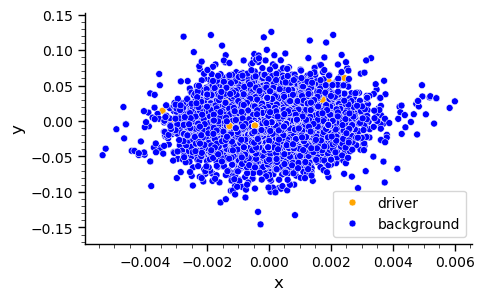

In [63]:
plot_embedding(E, driver_status)

# 5. Cluster and enrichment analysis for predicting cancer related genes

Having computed our embedding space, $E$, we want to use this space to make cancer driver gene predictions. We illustrate an unsupervised approach: we cluster the genes based on their proximity in the embedding space. For each cluster, we measure if it is enriched in known cancer drivers using a hypergeometric test (sampling without replacement). If a cluster is enriched, we predict the other genes in the cluster as potential drivers. You are provided with code to perform the clustering. We ask you to implement enrichment analysis based on the [hypergeometric distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html).

In [46]:
def enrichment_analysis(clustering, d, driver_status, genes):
    """ Compute the enrichment of drivers in each cluster of a clustering.

    parameters:
    -----------
    clustering: np.ndarray (n,)
        Array of cluster assignments for n nodes.
    d: number of clusters 

    driver_status: np.ndarray (n,)
        Array of driver status for n nodes. 1 if node is a driver, 0 otherwise.

    returns:
    --------
    """

    from scipy.stats import hypergeom

    for i in range(d):

        cluster = np.where(clustering == i)[0] 
         
        # We want to compute what is the probability of observing at least k drivers in the cluster
        # For this we us the hypergeom distribution from scipy and the survival function (sf):
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.hypergeom.html
        # The sf function (i.e., the hypergeometric test) takes the following parameters
        # M the size of the population, i.e., the total number of nodes in our network
        # n the number of success in the population, i.e., the total number of drivers
        # N is the number of draws, i.e., the number of nodes in the cluster
        # k is the number of success in the draws, i.e., the number of drivers in the cluster
        
        # TODO: compute M, n, N, k below
       
        M = len(clustering)
        n = driver_status.sum()
        N = len(cluster)
        k = driver_status[cluster].sum()

        # END TODO

        # n is the number of
        pval = hypergeom.sf(k, M, n, N,)
        pval_adj = pval * d  # Bonferroni correction

        if pval_adj < 0.05:
            print(f"Cluster {i} is enriched for drivers with adjusted p-value {pval_adj}")
            predicted_entrez_ids = [genes[i] for i in cluster if driver_status[i] == 0]
            mapped_genes = map_entrez_to_symbol(predicted_entrez_ids)
            print(f"predictions in cluster {i}: {mapped_genes}")
            print("\n")



In [47]:
E_normalized = normalize(E) # normalise to unit norm
clustering = KMeans(n_clusters=d, random_state=0, n_init="auto").fit_predict(E_normalized)
enrichment_analysis(clustering, d, driver_status, list(G.nodes()))

Cluster 0 is enriched for drivers with adjusted p-value 0.011840805958482742
predictions in cluster 0: ['RALBP1', 'ZDHHC17', 'TCF3', 'VAV1', 'PIK3R3', 'APOA1', 'EXOC8', 'HBP1', 'BRD8', 'LMO2', 'TNFRSF1A', 'TBP', 'NCK1', 'TIAM1', 'SIAH1', 'UBE2D2', 'GOPC', 'RND1', 'PRKAB2', 'PPL', 'E2F6', 'URI1', 'HSPB8', 'TRIB3', 'RNF11', 'POLR1D', 'KLHL20', 'POLR2G', 'IFITM1', 'KRT15', 'CEP70', 'USHBP1', 'LGALS8', 'DAZAP2', 'MDFI', 'NEK6', 'OTX1', 'ZNF417', 'CCDC33', 'FBXW5', 'SORBS3', 'ZNF655', 'STX8', 'VTI1B', 'SGTA', 'MBIP', 'ADAMTSL4', 'ZNF408', 'KHDRBS2', 'CEP76', 'MTUS2', 'SGF29', 'USP2', 'HOOK2', 'RCOR3', 'S100P', 'YIPF3', 'GEM', 'ZNF263', 'ZUP1', 'CCDC120', 'NDEL1', 'SEM1', 'KBTBD7', 'SNAP29', 'TANK', 'FTH1', 'NCK2', 'SCNM1', 'TRIM41', 'POLR2M', 'DYRK2', 'PCGF1', 'TCEA2', 'CARD9', 'TFPT', 'PMAIP1', 'MCC', 'CDK2AP1', 'KRT34', 'ANKS1A', 'DDX19B', 'SERPINB4', 'ATP2A3', 'HCK', 'CCNA2', 'CD79A', 'XRCC3', 'CCNC', 'MED20', 'POLR2F', 'INCA1', 'TNFRSF10B', 'RINT1', 'COP1', 'PLD2', 'AQP3', 'NOTCH2NLA', 

# 5. Extensions

For those that reach the end of this tutorial, we provide two extensions.  alternative notions of topological similarity can be considerd using graphlet adjacency or orbit adjacency instead of GDV similarity. 

For those that reach the "Extensions" section of this tutorial, you can also uncomment the lines that comptute the graphlet adjacency matrices or orbit adjacency matrices. We compute the GDV vectors and select one graphlet adjacency matrix ($A{G_{2}}$ by default) matrix and orbit adjacency matrix ($A_{o1--o1}$ by default) to analyse in the remainder of this nodebook. Feel free to change the chosen graphlet and orbit adjacency matrices.

As GRADCO is quite memory intensive and can take some time to compute the adjacency matrices (~5 minutes for the human PPI network, 16 GB of ram), we provide the option below to: (1) run GRADCO or (2) to read precomputed GDV vectors (under '/features/GDVs/'), graphlet adjacencies (under 'features/GAs') and orbit adjacencies (under 'features/orbit_adjacencies/'). 

Note that code for both options is provided to avoid technical issues. No code needs to be completed in this section.

## 5.1  Consider alternative notions of topological embeddings

GDV similarity captures the topological similarity between two nodes, regegardless if they are in eachothers neighbourhood in the network or not. So, the GDV similarity matrix computed above only captures if nodes are similarly wired, it does not take into account network proximity. 

To combine topological information and neighbourhood information graphlet adjacency and orbit adjacency measure the similarity between two nodes as their frequency of co-occurence on graphlets or a pair of orbits, respectively. So, to compute topology aware embeddings that also take neighbourhood information into account, we can use a graphlet adjacency matrix or orbit adjacency matrix instead. 

These adjacency matrices have been precomputed and are stored under '/features/GAs' and '/features/OAs', respectively. 

Feel free to use the lines below to load any of the matrices and use them to compute embeddings and perform clustering and enrichment analysis. 

In [275]:
GA = sparse.load_npz(f'features/GAs/GA_{net_name}_2.npz').toarray() 
assert GA.shape[0] == G.number_of_nodes(), 'The network and GA file should match'
OA = sparse.load_npz(f'features/OAs/OA_{net_name}_2_1_1.npz').toarray()  # orbit adjacency for nodes 2 hops appart on orbit 1 and 1 
assert OA.shape[0] == G.number_of_nodes(), 'The network and OA file should match'
# We add +1 to the off-diagonal ellements of GA and OA to avoid computational issues where a node doesn't touch an orbit or graphlet
OA[~np.eye(OA.shape[0], dtype=bool)] += 1
GA[~np.eye(GA.shape[0], dtype=bool)] += 1

## 5.2 Capturing longer range associations 

Applying LINE as an embedding algorithm can be interpreted as applying random walks of length 1 on an adjacency matrix. 
DeepWalk is a generalisation of LINE for walks up to length T. The clossed formula for the DeepWalk PPMI matrix is:
$$	DeepWalk-PPMI = log \left( vol(A) \left( \frac{1}{T} \sum\limits_{r=1}^{T} (D^{-1}A)^r \right) D^{-1} \right).$$

Feel free to complete the Deepwalk PPMI code below and use it instead of LINE to compute embeddings that capture longer range associations.


In [30]:
def compute_DeepWalk_PPMI(A, T):
    """ Compute the LINE PPMI matrix of adjacency matrix A.

    parameters:
    -----------

    A: np.ndarray (n x n)
        The adjacency matrix of a graph.

    T: int
        The maximum length of the random walk.

    returns:
    --------

    A: np.ndarray (n x n)
        The PPMI matrix of A.

    """


    epsilon = 1e-6
    # TODO: compute the DeepWalk embeddings of A.
    # TODO 1: compute sum of the rows and columns of A
    
    rowsums = A.sum(axis=1)
    colsums = A.sum(axis=0)

    # TODO 2: compute the volume of A 
    vol = rowsums.sum()

    # TODO 3: divide the rows of A by the rowsums
    A = A / rowsums[:, None]

    # TODO 4: compute the sum of the up to T-th power of A
    # be careful not to modify the original normalised A matrix. Use np.copy()
    A_power = np.copy(A)
    A_normalised = np.copy(A)
    for t in range(2, T+1):
        A_power = A_power * A_normalised
        A = A + A_power
    # TODO 5: divide the sum of A's by T
    A = A / T

    # TODO 6: divide the columns of the sum of A's A by the colsums
    A = A / colsums

    # TODO 5: multiply the normalised A by the volume
    A = A * vol

    # TODO 6: apply the entrywise log transform to A + epsilon (to avoid log(0))
    A = np.log(A + epsilon)
    assert np.isnan(A).sum() == 0, "NaN values in A"
    assert np.isinf(A).sum() == 0, "Inf values in A"

    # TODO 7: replace the negative values in A with 0
    A[A < 0] = 0
    assert (A < 0).sum() == 0, "Negative values in A"

    return A

In [287]:
%%time 
S = compute_GDV_similarity_matrix(GDVs)

CPU times: user 38min 6s, sys: 3.99 s, total: 38min 10s
Wall time: 38min 25s


In [289]:
np.savez_compressed(f"features/GDV_sim/GDV_sim_{net_name}", S.astype(np.float16))

In [64]:
import importlib
import plots
importlib.reload(plots)
from plots import *